In [19]:
import Pkg, Revise
using DrWatson
@quickactivate "sst-mot-analysis"

using GH19, TMI

import DrWatson: datadir, srcdir, plotsdir
!isdir(plotsdir()) && mkpath(plotsdir()) 

include(srcdir("CondaSSL.jl"))
using PythonPlot, PythonCall

using NaNStatistics, Interpolations, 
      Statistics, LinearAlgebra

const mtpl = pyimport("matplotlib");
const cartopy = pyimport("cartopy");
const matplotlib = pyimport("matplotlib");
const sns = pyimport("seaborn");
const cm = pyimport("cmocean.cm")

mtpl.rcParams["figure.dpi"] = 100
ccrs = cartopy.crs

custom_style = Dict("text.color" => "black")
sns.set_theme(context="notebook", style="ticks", palette = "colorblind", rc=custom_style, font_scale = 1.2)
ccrs = cartopy.crs;
cfeature = cartopy.feature

Python: <module 'cartopy.feature' from '/Users/anthonymeza/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/Documents/GitHub/sst-mot-analysis/.CondaPkg/.pixi/envs/default/lib/python3.12/site-packages/cartopy/feature/__init__.py'>

In [20]:
include(srcdir("load_GH19.jl"))
include(srcdir("decompose_discrete.jl"))
include(srcdir("blocksum.jl"))
include(srcdir("TMI_utils.jl"))

 takes about 10 minutes
Theta_OPT-0015.nc already downloaded; use `force=true` to re-download
Theta_anom_OPT-0015.nc already downloaded; use `force=true` to re-download


layerthickness (generic function with 1 method)

In [21]:
function get_area_normalized_volume_filled_bc(TMIversion,Alu,γ)
    volume = volumefilled(TMIversion,Alu,γ); 
    volume = (10 .^ volume.tracer)
    volume = BoundaryCondition(volume,(γ.lon,γ.lat),γ.depth[1],3,1,γ.wet[:, :, 1],:V,"volume filled by surface gridcell per area","m³/m²")
    return 1 * volume
end

function get_volume_filled_bc(volume_normalized, γ, areao)
    volume = volume_normalized.tracer .* Float64.(areao.tracer)
    volume = BoundaryCondition(volume,(γ.lon,γ.lat),γ.depth[1],3,1,volume_normalized.wet,:V,"volume filled by surface gridcell","m³")
    return 1 * volume
end

function get_MOT_and_SST(TMIfile::String, γ::Grid)
    θ̄ = readfield(TMIfile, "θ", γ); #true mean
    volume = cellvolume(γ).tracer 
    θ̄_MOT = nansum(θ̄.tracer .* volume) / nansum(volume)
    θ̄_SST = getsurfaceboundary(θ̄);

    return θ̄_MOT, θ̄_SST
end

function get_MOT_and_SST(θ̄::Field, γ::Grid)
    volume = cellvolume(γ).tracer 
    θ̄_MOT = nansum(θ̄.tracer .* volume) / nansum(volume)
    θ̄_SST = getsurfaceboundary(θ̄);

    return θ̄_MOT, θ̄_SST
end

surfacecellarea(γ) = cellarea(γ)

surfacecellarea (generic function with 1 method)

In [25]:
###### LOAD LGM ###########
TMI_version = "LGM_90x45x33_G14"
A, Alu, γ_lgm, TMIfile, L, B = config(DrWatson.datadir(), "TMI_" * TMI_version * "_compressed.nc")

volume_LGM_normalized = get_area_normalized_volume_filled_bc(TMIversion,Alu,γ_lgm)

volume_lgm = get_volume_filled_bc(volume_LGM_normalized, γ_lgm, surfacecellarea(γ_lgm))

θ̄_LGM_MOT, θ̄_LGM_SST = get_MOT_and_SST(TMIfile, γ_lgm);

###### LOAD PREINDUSTRIAL ###########
TMI_version = GH19.TMIversion();
A, Alu, γ_mod, TMIfile, L, B = config(TMI_version); 
TMIfile = TMI.pkgdatadir("TMI_"*TMI_version*".nc")

volume_mod_normalized_fine = get_area_normalized_volume_filled_bc(TMIversion,Alu,γ_mod)

volume_mod_fine = get_volume_filled_bc(volume_mod_normalized_fine, γ_mod, surfacecellarea(γ_mod))
θ̄GH19 = load_GH19_equillibrium()
θ̄_mod_MOT, θ̄_mod_SST_fine = get_MOT_and_SST(θ̄GH19, γ_mod);

/Users/anthonymeza/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/Documents/GitHub/sst-mot-analysis/data/TMI_LGM_90x45x33_G14_compressed.nc
Form water-mass matrix A
  0.028265 seconds (1.55 k allocations: 34.389 MiB)
LU factorization of A
  0.620157 seconds (88 allocations: 521.130 MiB, 1.29% gc time)
circulation matrix L=
  0.001864 seconds (257 allocations: 20.203 KiB)
Boundary matrix B=
  0.001449 seconds (256 allocations: 20.180 KiB)
Form water-mass matrix A
  0.061146 seconds (5.23 k allocations: 118.943 MiB, 8.85% gc time)
LU factorization of A
  4.578736 seconds (88 allocations: 2.810 GiB, 0.23% gc time)
circulation matrix L=
  0.123521 seconds (8.14 M allocations: 224.521 MiB)
Boundary matrix B=
  0.023710 seconds (6.14 k allocations: 7.270 MiB, 34.17% gc time)
Form water-mass matrix A
  0.027252 seconds (5.23 k allocations: 118.943 MiB)
LU factorization of A
  4.773902 seconds (88 allocations: 2.810 GiB, 1.17% gc time)
circulation matrix L=
  0.120172 seconds

In [26]:
weights = volume_mod_fine.tracer ./ nansum(volume_mod_fine.tracer)
weights[isnan.(weights)] .= 0.0

oarea_mod_coarse = coarse_grain_boundary_condition(
    surfacecellarea(γ_mod), γ_mod, γ_lgm,
    2, 2;
    method = :sum, use_area_weights = false, weights = nothing)

volume_mod = coarse_grain_boundary_condition(
    volume_mod_fine, γ_mod, γ_lgm,
    2, 2;
    method = :sum, use_area_weights = false, weights = nothing)

θ̄_mod_SST = coarse_grain_boundary_condition(
    θ̄_mod_SST_fine, γ_mod, γ_lgm,
    2, 2;
    method = :average, use_area_weights = false, weights = weights, var = :θ);


In [27]:
# print percent difference with label
function print_diff(label, coarse, truth; digits=2)
    perc_diff(x, y) = 100 * (x - y) / y
    pd = round(perc_diff(coarse, truth), digits=digits)
    println("$label: $pd %")
end

# weighted mean, ignoring NaNs
weighted_mean(weight, field) = nansum(weight .* field) / nansum(weight)


# ——————————————————————————————————————————————————————————————
# Compute true and coarse means for SST
# ——————————————————————————————————————————————————————————————
true_mod_SST    = weighted_mean(cellarea(γ_mod).tracer, θ̄_mod_SST_fine.tracer)
true_lgm_SST    = weighted_mean(cellarea(γ_lgm).tracer, θ̄_LGM_SST.tracer)
coarse_mod_SST  = weighted_mean(oarea_mod_coarse.tracer, θ̄_mod_SST.tracer)

print_diff("MEAN SST % DIFFERENCE", coarse_mod_SST, true_mod_SST)

# ——————————————————————————————————————————————————————————————
# Compute volume-weighted mean temperature (MOT)
# ——————————————————————————————————————————————————————————————
volume_mean(volume, tracer) = weighted_mean(volume.tracer, tracer.tracer)

true_eq_MOT_mod = volume_mean(volume_mod_fine, θ̄_mod_SST_fine)
true_eq_MOT_lgm = volume_mean(volume_lgm, θ̄_LGM_SST)
coarse_eq_MOT   = volume_mean(volume_mod, θ̄_mod_SST)

print_diff("MEAN OCE TMP % DIFFERENCE", coarse_eq_MOT, true_eq_MOT_mod)

# ——————————————————————————————————————————————————————————————
# Compute and compare ΔSST and ΔOCE TMP
# ——————————————————————————————————————————————————————————————
Δ_true_SST      = true_mod_SST    - true_lgm_SST
Δ_coarse_SST    = coarse_mod_SST  - true_lgm_SST
Δ_true_eq_MOT   = true_eq_MOT_mod - true_eq_MOT_lgm
Δ_coarse_eq_MOT = coarse_eq_MOT   - true_eq_MOT_lgm

print_diff("MEAN ΔSST TMP % DIFFERENCE", Δ_coarse_SST,    Δ_true_SST)
print_diff("MEAN ΔOCE TMP % DIFFERENCE", Δ_coarse_eq_MOT, Δ_true_eq_MOT)
print_diff("MEAN ΔOCE/ΔSST TMP % DIFFERENCE", Δ_coarse_eq_MOT/Δ_coarse_SST, Δ_true_eq_MOT/Δ_true_SST)

MEAN SST % DIFFERENCE: -0.54 %
MEAN OCE TMP % DIFFERENCE: 0.0 %
MEAN ΔSST TMP % DIFFERENCE: -4.38 %
MEAN ΔOCE TMP % DIFFERENCE: 0.0 %
MEAN ΔOCE/ΔSST TMP % DIFFERENCE: 4.58 %


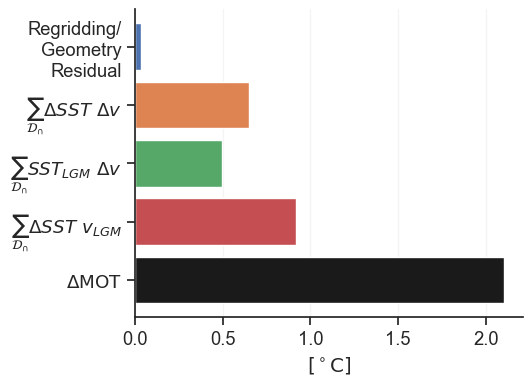

Python: None

In [28]:
D_mod = copy(θ̄_mod_SST.wet)
SST_mod = 1 .* θ̄_mod_SST.tracer; SST_mod[.!D_mod] .= 0.0;
w_mod = 1 .* volume_mod.tracer; w_mod[.!D_mod] .= 0.0;
w_mod = 1 .* w_mod ./ nansum(w_mod)

D_lgm = copy(θ̄_LGM_SST.wet)
SST_lgm = 1 .* θ̄_LGM_SST.tracer; SST_lgm[.!D_lgm] .= 0.0;
w_lgm = 1 .*  volume_lgm.tracer; w_lgm[.!D_lgm] .= 0.0;
w_lgm = 1 .*  w_lgm ./ nansum(w_lgm); w_lgm[isnan.(w_lgm)] .= 0.0


res = decompose_discrete_full(
    SST_lgm, SST_mod,
    D_lgm, D_mod,
    w_lgm, w_mod)

true_mot_change = (θ̄_mod_MOT - θ̄_LGM_MOT)
residual = true_mot_change .- (res.integrand_change + res.weight_change + res.overlap_interaction)

term_dict = Dict("regridding_geometry_residual" => residual,
                 "integrand_change" => res.integrand_change,
                 "weight_change" => res.weight_change,
                 "overlap_interaction" => res.overlap_interaction, 
                 "dMOT" => true_mot_change)

term_label_dict = Dict("regridding_geometry_residual" => "Regridding/\nGeometry\nResidual",
                       "integrand_change" => raw"$\sum_{\mathcal{D}_{\cap}} \Delta SST ~ v_{LGM}$",
                       "weight_change" => raw"$\sum_{\mathcal{D}_{\cap}}  SST_{LGM} ~ \Delta v$",
                       "overlap_interaction" => raw"$\sum_{\mathcal{D}_{\cap}}  \Delta SST ~ \Delta v$",
                       "dMOT" => raw"$\Delta \text{MOT}$")

fig, axes = subplots(1; sharey=true, figsize=(5, 4))

plot_terms = ["regridding_geometry_residual", "overlap_interaction", "weight_change", "integrand_change", "dMOT"]
colors_terms = sns.color_palette("deep", length(plot_terms)); colors_terms[-1] = "k"
plot_terms = reverse(plot_terms); colors_terms = reverse(collect(colors_terms))

axes.barh([term_label_dict[k] for k in plot_terms], [term_dict[k] for k in plot_terms], color=colors_terms)
axes.set_xlabel(L"[^\circ\text{C}]")
axes.grid(alpha = 0.2, zorder = 0, axis = "x")
axes.spines["top"].set_visible(false)
axes.spines["right"].set_visible(false)
fig.savefig(plotsdir("2.MOT_Change_decomposition_horizontal.png"); dpi=200, bbox_inches="tight")


sys:1: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
sys:1: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


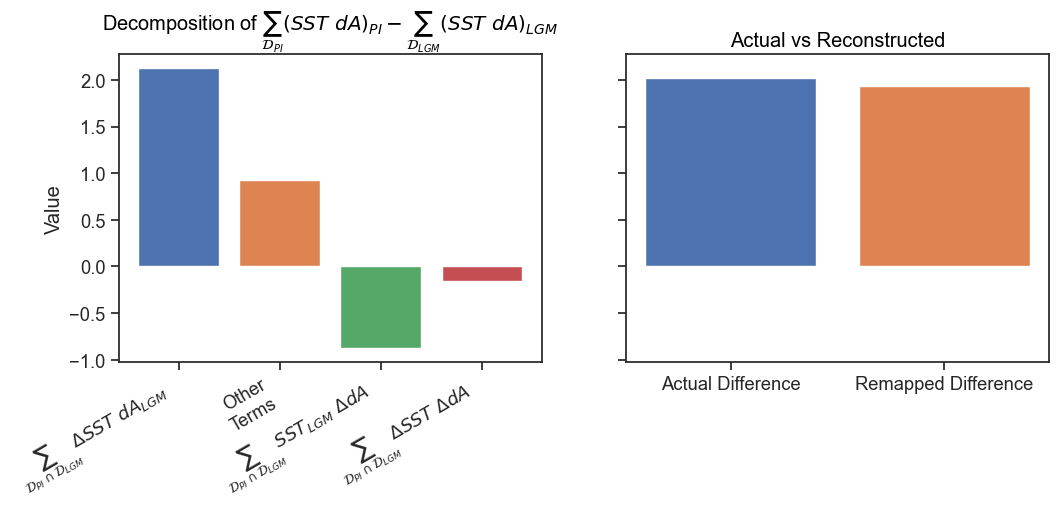

Python: Text(0.5, 1.0, 'Actual vs Reconstructed')

In [29]:
D_mod = copy(θ̄_mod_SST.wet)
SST_mod = 1 .* θ̄_mod_SST.tracer; SST_mod[.!D_mod] .= 0.0;
w_mod = 1 .* oarea_mod_coarse.tracer; w_mod[.!D_mod] .= 0.0;
w_mod = 1 .* w_mod ./ nansum(w_mod)

D_lgm = copy(θ̄_LGM_SST.wet)
SST_lgm = 1 .* θ̄_LGM_SST.tracer; SST_lgm[.!D_lgm] .= 0.0;
w_lgm = 1 .* surfacecellarea(γ_lgm).tracer; w_lgm[.!D_lgm] .= 0.0;
w_lgm = 1 .*  w_lgm ./ nansum(w_lgm); w_lgm[isnan.(w_lgm)] .= 0.0

res = decompose_discrete_full(
    SST_lgm, SST_mod,
    D_lgm, D_mod,
    w_lgm, w_mod
)

true_sst_change =  true_mod_SST    - true_lgm_SST
#change in tMOT explained by addtl terms and other errors
residual = true_sst_change .- (res.integrand_change + res.weight_change + res.overlap_interaction)

term_dict = Dict("Other\nTerms" => residual,
    raw"$\sum_{\mathcal{D}_{PI} \cap \mathcal{D}_{LGM}} \Delta SST ~ dA_{LGM}$" => res.integrand_change,
    raw"$\sum_{\mathcal{D}_{PI} \cap \mathcal{D}_{LGM}}  SST_{LGM} ~ \Delta dA$" => res.weight_change,
    raw"$\sum_{\mathcal{D}_{PI} \cap \mathcal{D}_{LGM}}  \Delta SST ~ \Delta dA$" => res.overlap_interaction)

diff_dict = Dict("Actual Difference" => true_sst_change, "Remapped Difference" =>res.total_decomposed)

# get colors
colors_terms = sns.color_palette("deep", term_dict.count)
colors_diff  = sns.color_palette("deep", diff_dict.count)

# make a 1×2 figure, sharing y-axis
fig, axes = subplots(1, 2; sharey=true, figsize=(12, 4))

# left plot: decomposition terms
axes[0].bar(keys(term_dict), [term_dict[k] for k in keys(term_dict)], color=colors_terms)
axes[0].set_xticklabels(keys(term_dict), rotation=30, ha="right")
axes[0].set_title("Decomposition of " * L"\sum_{\mathcal{D}_{PI}} (SST ~ dA)_{PI} - \sum_{\mathcal{D}_{LGM}} (SST ~ dA)_{LGM}")
axes[0].set_ylabel("Value")

# right plot: actual vs reconstructed
axes[1].bar(keys(diff_dict), [diff_dict[k] for k in keys(diff_dict)]; color=colors_diff)
axes[1].set_xticklabels(keys(diff_dict), rotation=0, ha="center")
axes[1].set_title("Actual vs Reconstructed")
